In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_log_error as rmsle
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import KFold, train_test_split, cross_val_score
import sklearn.metrics
import xgboost as xgb
import seaborn as sns
import itertools
import optuna
from catboost import CatBoostRegressor, Pool

In [3]:
train = pd.read_csv("train_comp.csv")
test = pd.read_csv("test_comp.csv")
# sample = pd.read_csv("sample_submission.csv")

train.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,36,189,82,26,101,41.0,150
1,female,64,163,60,8,85,39.7,34
2,female,51,161,64,7,84,39.8,29
3,male,20,192,90,25,105,40.7,140
4,female,38,166,61,25,102,40.6,146


In [4]:
numerical_features = ["Age","Height","Weight","Duration","Heart_Rate","Body_Temp"]

def add_feats(df, numerical_features):
    ''''''''''
    Inputs: dataframe df
    Output: the modified dataframe with cross terms, BMI, id+calories removed, and sex as categorical variable
    '''''''''
    df_new = df.copy()

    features = df_new.columns

    if 'id' in features:
        df_new = df_new.drop(columns=['id'])
    
    if 'Calories' in features:
        df_new = df_new.drop(columns=['Calories'])
    
    
    df_new['Sex'] = df_new['Sex'].astype('category')

    df_new['BMI'] = df_new['Weight']/((df_new['Height']/100)**2)

    df_new['Body_Temp_-_min_sq'] = (df_new['Body_Temp']-df_new['Body_Temp'].min())**2

    for i in range(len(numerical_features)):
        for j in range(i + 1, len(numerical_features)):  
            feature1 = numerical_features[i]
            feature2 = numerical_features[j]
            cross_term_name = f"{feature1}_x_{feature2}"
            df_new[cross_term_name] = df_new[feature1] * df_new[feature2]
            cross_term_name = f"{feature1}_divided_{feature2}"
            df_new[cross_term_name] = df_new[feature1] / df_new[feature2]

    return df_new

In [5]:
y = np.log1p(train['Calories'])

X = add_feats(train, numerical_features)

X.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Body_Temp_-_min_sq,Age_x_Height,...,Weight_x_Heart_Rate,Weight_divided_Heart_Rate,Weight_x_Body_Temp,Weight_divided_Body_Temp,Duration_x_Heart_Rate,Duration_divided_Heart_Rate,Duration_x_Body_Temp,Duration_divided_Body_Temp,Heart_Rate_x_Body_Temp,Heart_Rate_divided_Body_Temp
0,male,36,189,82,26,101,41.0,22.955684,15.21,6804,...,8282,0.811881,3362.0,2.000000,2626,0.257426,1066.0,0.634146,4141.0,2.463415
1,female,64,163,60,8,85,39.7,22.582709,6.76,10432,...,5100,0.705882,2382.0,1.511335,680,0.094118,317.6,0.201511,3374.5,2.141058
2,female,51,161,64,7,84,39.8,24.690405,7.29,8211,...,5376,0.761905,2547.2,1.608040,588,0.083333,278.6,0.175879,3343.2,2.110553
3,male,20,192,90,25,105,40.7,24.414062,12.96,3840,...,9450,0.857143,3663.0,2.211302,2625,0.238095,1017.5,0.614251,4273.5,2.579853
4,female,38,166,61,25,102,40.6,22.136740,12.25,6308,...,6222,0.598039,2476.6,1.502463,2550,0.245098,1015.0,0.615764,4141.2,2.512315


In [6]:
test_mod = add_feats(test, numerical_features)

test_mod.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Body_Temp_-_min_sq,Age_x_Height,...,Weight_x_Heart_Rate,Weight_divided_Heart_Rate,Weight_x_Body_Temp,Weight_divided_Body_Temp,Duration_x_Heart_Rate,Duration_divided_Heart_Rate,Duration_x_Body_Temp,Duration_divided_Body_Temp,Heart_Rate_x_Body_Temp,Heart_Rate_divided_Body_Temp
0,male,45,177,81,7,87,39.8,25.854639,7.29,7965,...,7047,0.931034,3223.8,2.035176,609,0.080460,278.6,0.175879,3462.6,2.185930
1,male,26,200,97,20,101,40.5,24.250000,11.56,5200,...,9797,0.960396,3928.5,2.395062,2020,0.198020,810.0,0.493827,4090.5,2.493827
2,female,29,188,85,16,102,40.4,24.049344,10.89,5452,...,8670,0.833333,3434.0,2.103960,1632,0.156863,646.4,0.396040,4120.8,2.524752
3,female,39,172,73,20,107,40.6,24.675500,12.25,6708,...,7811,0.682243,2963.8,1.798030,2140,0.186916,812.0,0.492611,4344.2,2.635468
4,female,30,173,67,16,94,40.5,22.386314,11.56,5190,...,6298,0.712766,2713.5,1.654321,1504,0.170213,648.0,0.395062,3807.0,2.320988


In [ ]:
def objective(trial):
    # X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=724)
    

    params = {
        'iterations': trial.suggest_int('iterations', 500, 1500, step=50),
        'depth': trial.suggest_int('depth', 9, 14),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, step=0.01),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 1e2, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 1e-8, 1.0, log=True),
        'border_count': 255,
        'task_type': 'GPU',
    }



    # Initialize the model with the suggested hyperparameters
    model = CatBoostRegressor(
        **params,
        loss_function='RMSE',
        random_state=724,
        verbose=0,
        early_stopping_rounds=50
    )

    # Cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=724)
    
    scores = []

    # Perform cross-validation manually
    for train_index, test_index in kf.split(X):
        X_train, X_val = X.loc[train_index], X.loc[test_index]
        y_train, y_val = y.loc[train_index], y.loc[test_index]
        
        # Create pool for validation to enable early stopping
        train_pool = Pool(X_train, y_train, cat_features=[0])
        val_pool = Pool(X_val, y_val, cat_features=[0])

        # Train and evaluate
        model.fit(train_pool, eval_set=val_pool, verbose=False)
        predictions = model.predict(X_val)
        
        # Calculate the score
        score = rmse(y_val, predictions)
        scores.append(score)
    

    # Calculate mean RMSE
    error = np.mean(scores)
    return error





if __name__ == "__main__":
    study = optuna.create_study(direction="minimize", study_name='cb_more_FE_withCV_2', storage="sqlite:///catboost.db", load_if_exists=True)
    study.optimize(objective, n_trials=200, timeout=30800)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2025-06-17 09:44:24,045] A new study created in RDB with name: cb_more_FE_withCV_2
[I 2025-06-17 09:45:51,472] Trial 0 finished with value: 0.05967813978334759 and parameters: {'iterations': 700, 'depth': 11, 'learning_rate': 0.060000000000000005, 'l2_leaf_reg': 0.6435887744131287, 'bagging_temperature': 0.09710921781498383}. Best is trial 0 with value: 0.05967813978334759.
[I 2025-06-17 09:46:35,122] Trial 1 finished with value: 0.06014761829921613 and parameters: {'iterations': 900, 'depth': 9, 'learning_rate': 0.12, 'l2_leaf_reg': 0.0017623738179154405, 'bagging_temperature': 7.947791107900671e-08}. Best is trial 0 with value: 0.05967813978334759.
[I 2025-06-17 09:47:54,372] Trial 2 finished with value: 0.059998039638168646 and parameters: {'iterations': 550, 'depth': 12, 'learning_rate': 0.09999999999999999, 'l2_leaf_reg': 0.00014816744293175068, 'bagging_temperature': 3.309896979240662e-06}. Best is trial 0 with value: 0.05967813978334759.
[I 2025-06-17 09:50:31,594] Trial 3 fi


Train prediction: 0.052999422465663026
Test prediction: 0.05953494791463264


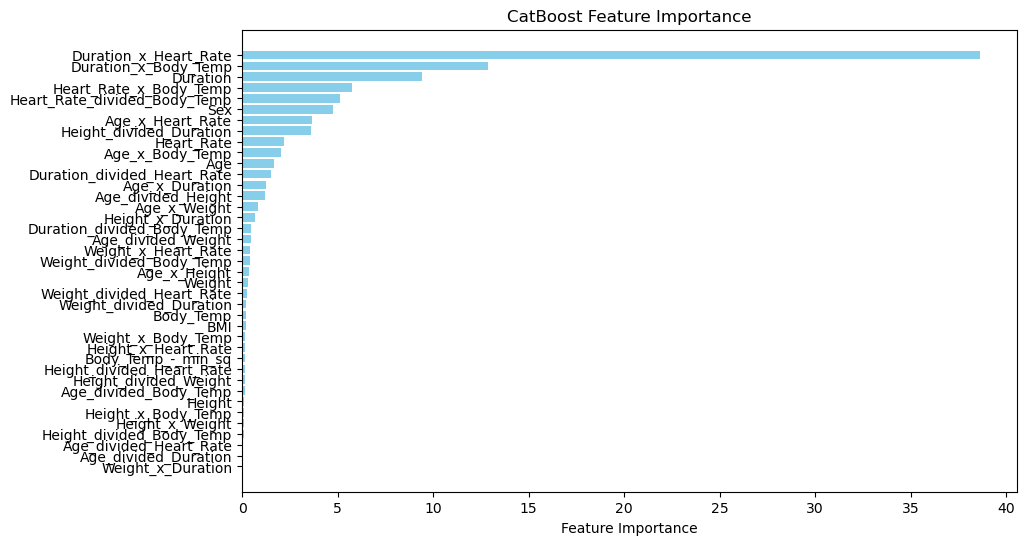

       id    Calories
0  750000   27.681525
1  750001  108.805891
2  750002   87.407504
3  750003  125.117357
4  750004   76.146645

count    250000.000000
mean         88.177416
std          62.273632
min           1.058497
25%          34.002471
50%          76.436556
75%         135.401415
max         298.054440
Name: Calories, dtype: float64


In [ ]:
# Kaggle score 0.05917 priv, 0.05726 public, cb_prediction_7.csv

# Best trial:
#   Value: 0.0595509249511218
#   Params: 
#     iterations: 1200
#     depth: 14
#     learning_rate: 0.014617853048658345
#     l2_leaf_reg: 0.13429777272521906
#     bagging_temperature: 0.0045899402382319834
#     border_count: 254

num_indices = 600000

train_index = np.random.choice(X.index, size=num_indices, replace=False)
test_index = list(set(np.arange(len(X))) - set(train_index))


X_train, X_test = X.loc[train_index], X.loc[test_index]
y_train, y_test = y.loc[train_index], y.loc[test_index]

# Define parameters
params = {
    'iterations': 1200,
    'learning_rate': 0.014617853048658345,
    'learning_rate': 0.014617853048658345,
    'l2_leaf_reg': 0.13429777272521906,
    'bagging_temperature': 0.0045899402382319834,
    'border_count': 254,
    'depth': 14,                 # max depth is 16
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'early_stopping_rounds': 50,
    #'subsample': ss,
    'task_type': 'GPU',
    'verbose': -1
}

# Train the model
model = CatBoostRegressor(**params)
model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=0, cat_features=[0])


# Make predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Evaluate
print()
print("Train prediction:", rmse(train_pred, y_train))
print("Test prediction:", rmse(test_pred, y_test))


# Get feature importances
feature_importances = model.get_feature_importance()

# Get feature names
feature_names = X_train.columns

# Sort feature importances and names
sorted_idx = feature_importances.argsort()
sorted_importances = feature_importances[sorted_idx]
sorted_names = feature_names[sorted_idx]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_names, sorted_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("CatBoost Feature Importance")
plt.show()


# make the submission file!
pred = model.predict(test_mod)

submission = pd.DataFrame()

submission['id'] = np.arange(len(test_mod))+750000
submission['Calories'] = np.expm1(pred)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1

submission.to_csv("cb_prediction_7.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

Test prediction: 0.05922324367312883
Train prediction: 0.05346039465352097


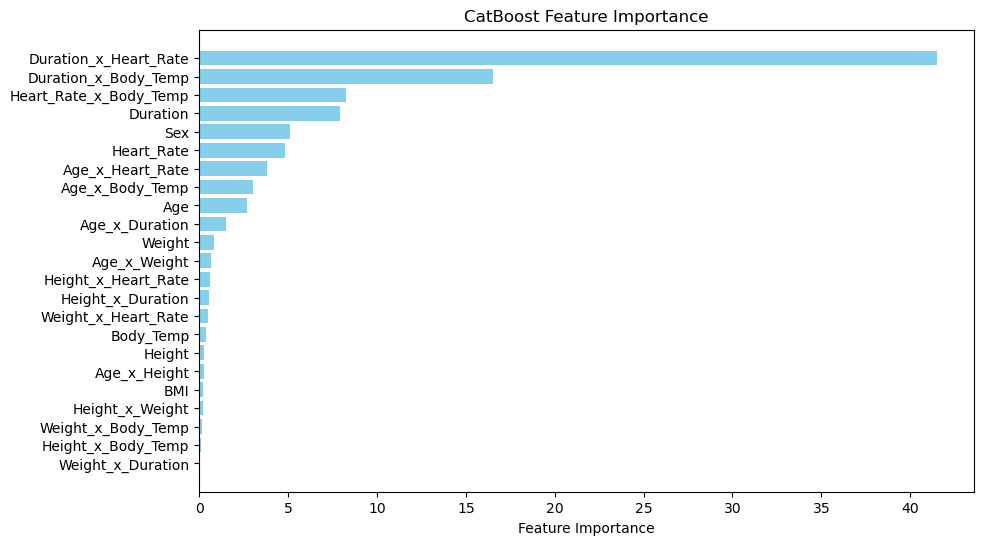

In [ ]:
# Kaggle score 0.05917 priv, 0.05763 public, cb_prediction_6.csv

# Best trial:
#   Value: 0.05950511443172714
#   Params: 
#     iterations: 1120
#     depth: 14
#     learning_rate: 0.019881973900568724
#     l2_leaf_reg: 0.0006419315876022216
#     bagging_temperature: 1.0731991179379209e-07
#     border_count: 225

num_indices = 600000

train_index = np.random.choice(X.index, size=num_indices, replace=False)
test_index = list(set(np.arange(len(X))) - set(train_index))


X_train, X_test = X.loc[train_index], X.loc[test_index]
y_train, y_test = y.loc[train_index], y.loc[test_index]

# Define parameters
params = {
    'iterations': 1120,
    'depth': 14,
    'learning_rate': 0.019881973900568724,
    'l2_leaf_reg': 0.0006419315876022216,
    'bagging_temperature': 1.0731991179379209e-07,
    'border_count': 225,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'early_stopping_rounds': 50,
    #'subsample': ss,
    'task_type': 'GPU',
    'verbose': -1
}

# Train the model
model = CatBoostRegressor(**params)
model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=0, cat_features=[0])


# Make predictions
y_pred = model.predict(X_test)
y_pred[y_pred <= 0] = 1
print("Test prediction:", rmse(y_test, y_pred))

# Make predictions
train_pred = model.predict(X_train)

# Ensure non-negative predictions (important for RMSLE)
train_pred[train_pred < 0] = 1

print("Train prediction:", rmse(train_pred, y_train))


# Get feature importances
feature_importances = model.get_feature_importance()

# Get feature names
feature_names = X_train.columns

# Sort feature importances and names
sorted_idx = feature_importances.argsort()
sorted_importances = feature_importances[sorted_idx]
sorted_names = feature_names[sorted_idx]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_names, sorted_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("CatBoost Feature Importance")
plt.show()

Test prediction: 0.060343074400381363
Train prediction: 0.05344072791903854


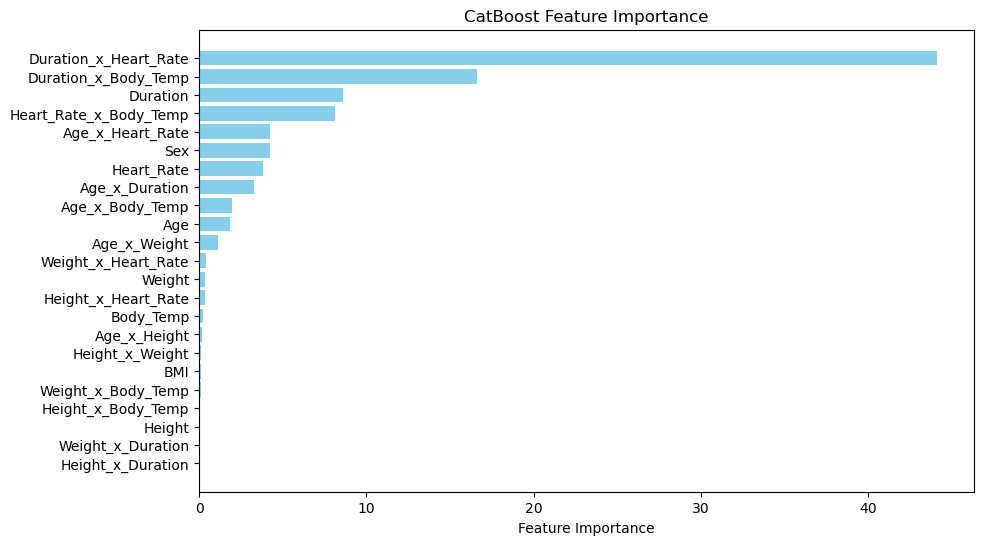

In [ ]:
# Kaggle score 0.05922 priv, 0.05823 public, cb_prediction_5.csv

# Best trial:
#   Value: 0.059658057482489035
#   Params: 
#     iterations: 995
#     depth: 10
#     learning_rate: 0.04444183851602489
#     l2_leaf_reg: 6.361250999342214e-05
#     bagging_temperature: 8.922652276190107e-06
#     border_count: 190

num_indices = 600000

train_index = np.random.choice(X.index, size=num_indices, replace=False)
test_index = list(set(np.arange(len(X))) - set(train_index))


X_train, X_test = X.loc[train_index], X.loc[test_index]
y_train, y_test = y.loc[train_index], y.loc[test_index]

# Define parameters
params = {
    'iterations': 995,
    'depth': 10,
    'learning_rate': 0.04444183851602489,
    'l2_leaf_reg': 6.361250999342214e-05,
    'bagging_temperature': 8.922652276190107e-06,
    'border_count': 190,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'early_stopping_rounds': 50,
    #'subsample': ss,
    'task_type': 'GPU',
    'verbose': -1
}

# Train the model
model = CatBoostRegressor(**params)
model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=0, cat_features=[0])


# Make predictions
y_pred = model.predict(X_test)
y_pred[y_pred <= 0] = 1
print("Test prediction:", rmse(y_test, y_pred))

# Make predictions
train_pred = model.predict(X_train)

# Ensure non-negative predictions (important for RMSLE)
train_pred[train_pred < 0] = 1

print("Train prediction:", rmse(train_pred, y_train))


# Get feature importances
feature_importances = model.get_feature_importance()

# Get feature names
feature_names = X_train.columns

# Sort feature importances and names
sorted_idx = feature_importances.argsort()
sorted_importances = feature_importances[sorted_idx]
sorted_names = feature_names[sorted_idx]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_names, sorted_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("CatBoost Feature Importance")
plt.show()

Test prediction: 0.060102237078677
Train prediction: 0.05163711063345169


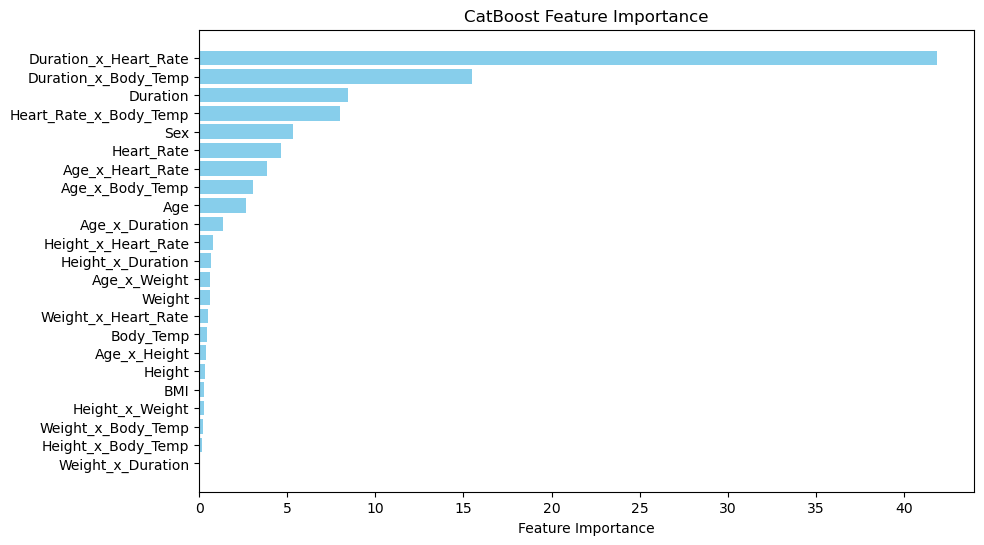

In [ ]:
# Kaggle score 0.05741, cb_prediction_4.csv

# Best trial:
#   Value: 0.0595284511851618
#   Params: 
#     iterations: 1197
#     depth: 14
#     learning_rate: 0.028749323259286183
#     l2_leaf_reg: 0.12260522714595841
#     bagging_temperature: 0.004141526359855983
#     border_count: 130

num_indices = 600000

train_index = np.random.choice(X.index, size=num_indices, replace=False)
test_index = list(set(np.arange(len(X))) - set(train_index))


X_train, X_test = X.loc[train_index], X.loc[test_index]
y_train, y_test = y.loc[train_index], y.loc[test_index]

# Define parameters
params = {
    'iterations': 1197,
    'learning_rate': 0.028749323259286183,
    'depth': 14,
    'l2_leaf_reg': 0.12260522714595841,
    'bagging_temperature': 0.004141526359855983,
    'border_count': 130,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'early_stopping_rounds': 50,
    #'subsample': ss,
    'task_type': 'GPU',
    'verbose': -1
}

# Train the model
model = CatBoostRegressor(**params)
model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=0, cat_features=[0])


# Make predictions
y_pred = model.predict(X_test)
y_pred[y_pred <= 0] = 1
print("Test prediction:", rmse(y_test, y_pred))

# Make predictions
train_pred = model.predict(X_train)

# Ensure non-negative predictions (important for RMSLE)
train_pred[train_pred < 0] = 1

print("Train prediction:", rmse(train_pred, y_train))


# Get feature importances
feature_importances = model.get_feature_importance()

# Get feature names
feature_names = X_train.columns

# Sort feature importances and names
sorted_idx = feature_importances.argsort()
sorted_importances = feature_importances[sorted_idx]
sorted_names = feature_names[sorted_idx]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_names, sorted_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("CatBoost Feature Importance")
plt.show()

In [21]:
test_mod = add_feats(test, numerical_features)

test_mod.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Age_x_Height,Age_x_Weight,...,Height_x_Weight,Height_x_Duration,Height_x_Heart_Rate,Height_x_Body_Temp,Weight_x_Duration,Weight_x_Heart_Rate,Weight_x_Body_Temp,Duration_x_Heart_Rate,Duration_x_Body_Temp,Heart_Rate_x_Body_Temp
0,male,45,177,81,7,87,39.8,25.854639,7965,3645,...,14337,1239,15399,7044.6,567,7047,3223.8,609,278.6,3462.6
1,male,26,200,97,20,101,40.5,24.250000,5200,2522,...,19400,4000,20200,8100.0,1940,9797,3928.5,2020,810.0,4090.5
2,female,29,188,85,16,102,40.4,24.049344,5452,2465,...,15980,3008,19176,7595.2,1360,8670,3434.0,1632,646.4,4120.8
3,female,39,172,73,20,107,40.6,24.675500,6708,2847,...,12556,3440,18404,6983.2,1460,7811,2963.8,2140,812.0,4344.2
4,female,30,173,67,16,94,40.5,22.386314,5190,2010,...,11591,2768,16262,7006.5,1072,6298,2713.5,1504,648.0,3807.0


In [22]:
# make the submission file!

pred = model.predict(test_mod)

submission = pd.DataFrame()

submission['id'] = np.arange(len(test_mod))+750000
submission['Calories'] = np.expm1(pred)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1

submission.to_csv("cb_prediction_6.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

       id    Calories
0  750000   27.063890
1  750001  107.331695
2  750002   87.150426
3  750003  124.014188
4  750004   75.896982

count    250000.000000
mean         88.175054
std          62.273936
min           0.975349
25%          34.007909
50%          76.446660
75%         135.374135
max         294.296540
Name: Calories, dtype: float64
